In [ ]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

This code is to show how the black-box variational inference with $\textbf{time-inhomogeneous}$ OU processes work under the observations from OU processes.

**Class: OU processes**

In [ ]:
class OU:
    def __init__(self, t0, t1, z0, m0, alpha, beta, sigma, r, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.m0 = m0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.r = r
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        
        beta_t = self.alpha * ((( self.pts[:-1] + 1) ** self.beta) - 1 ) + self.m0 \
                - np.exp(self.r * interval) * (self.alpha * (((self.pts[1:] + 1)**self.beta) - 1) + self.m0)

        for t in range(1, len(self.pts)):
            # if the distance is too small, variance becomes 0
            mean = (output[t-1] - beta_t[t-1]) * np.exp(-1 * self.r * interval[t-1] )
            sd = np.sqrt(self.sigma * interval[t-1])
#             print(mean, sd)
            assert sd > 0, "standard deviation is negative, sd:%.3f interval: %.3f" % (sd, interval[t-1] )
            output[t] = ss.norm.rvs(loc = mean, scale = sd)
            
        return torch.from_numpy(output), interval

Variational inference: KL

In [ ]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha, self.beta, self.sigma, self.r, self.m0 = torch.tensor([ou.alpha, ou.beta, ou.sigma, ou.r, ou.m0])
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func = lambda s, z: -0.5 * (1-(r**2)) * z ** 2 + alpha * beta * (B(s, beta-1) + 1) * z \
                    -0.5 * ((r**2) - 1) * (alpha**2) * (beta**2) * B(s, 2*(beta-1)) \
                    -0.5 * (alpha * (B(s, beta) - 1) + m0 + r * alpha * beta * B(s, beta-1)) \
                    * (2 * z - alpha * (B(s, beta) - 1) - m0 - r * alpha * beta *B(s, beta - 1))
        
        func_kl = vmap(func)
        return torch.trapezoid(abs(func_kl(self.ou.pts, self.ou.trj)), x=self.ou.pts)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        z0 = self.ou.z0
        z1 = self.ou.trj[-1]
        t0 = self.ou.t0
        t1 = self.ou.t1
        
        # Obtain the rest 
        def A(s, u):
            return (r - 1) * 0.5 * (u ** 2) - u * r * alpha * (((s+1) ** beta) - 1) - r * m0 * u - alpha * beta * (s+1) * u
        
        return A(t1, z1) - A(t0, z0) - 0.5 * (r - 1) * (t1 - t0)
    
    def log_prob(self, obs):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
        """
        def log_pdf(obs, z):
            return ss.norm.logpdf(obs, loc=z, scale=.001)
            
        
        return log_pdf(obs, self.ou.trj[-1])


In [ ]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        
        sigma = torch.tensor(self.ou.sigma)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = True)
        m0 = Variable(m0, requires_grad = False)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
 
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            """
            beta_t = alpha * (((pts[:-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[1:] + 1) ** beta) - 1) + m0) 
            term2 = X[1:] - (X[:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = 2 * (sigma ** 2) * dt
            return -1 * torch.sum(term2 ** 2 / term3)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)

        NLL.backward()
        
        return {'beta':beta.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}


**Generate observations from Gaussian likelihood**

Noisy Observations from the SDE:

$dX_{t} = -X_{t}dt + \sigma dW_{t}$

In [ ]:
true_sde = OU(t0 = 0, t1 = 1, z0 = 0, m0 = 0, alpha = 0.124, beta = 2.43, sigma = 1, r = -0.124, dN = 1000)

In [ ]:
plt.plot(true_sde.pts, true_sde.trj, 'rx')
plt.title(r"time-dependent OU: $\alpha$ = %.2f" % true_sde.alpha + r", $\beta$ = %.2f" % true_sde.beta + r", $\sigma$ = %.2f" % true_sde.sigma \
          + r", $m_0$ = %.2f" % true_sde.m0 + r", $r$ = %0.2f" % true_sde.r)
plt.show()

In [ ]:
obs = np.random.normal(loc = true_sde.trj[::100], scale = .001)
obs_time = true_sde.pts[::100]

In [ ]:
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts, true_sde.trj, '--')
plt.plot(true_sde.pts[::100], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

**Variational inference: a piece-wise approximation**

1. one-time variational inference from t=0 to t=1

In [ ]:
import tqdm as tq

In [55]:
beta_ = 1.
alpha_ = 1.
r_ = 0.5
m0 = true_sde.m0

N = 50
N_e = 50
learning_rate = 0.00001

trace_pars = []
trace_elbo = []
for k in tq.tqdm(range(300)):
    beta_grad = 0.
    alpha_grad = 0.
    r_grad = 0.

    for i in range(N):
        vi = OU(t0 = obs_time[0], t1 = obs_time[1], z0 = obs[0], m0 = 0, alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
        elbo = ELBO(vi)
        score = Score(vi)
        
        scores = score.compute_score(torch.tensor(alpha_, dtype=torch.float64), torch.tensor(beta_, dtype=torch.float64)\
                                    , torch.tensor(m0, dtype=torch.float64), torch.tensor(r_, dtype=torch.float64))
        f_of_X = -1 * (elbo.log_prob(obs[1]) + elbo.KL_ito() + elbo.KL_rest())
        beta_grad += f_of_X * scores['beta']
        alpha_grad += f_of_X * scores['alpha']
        r_grad += f_of_X * scores['r']
        
    beta_ -= learning_rate * (beta_grad/N).numpy()
    alpha_ -= learning_rate * (alpha_grad/N).numpy()
    r_ -= learning_rate * (r_grad/N).numpy()

    
    elbo_estimate = 0
    for j in range(N_e):
        vi_ = OU(t0 = obs_time[0], t1=obs_time[1], z0 = obs[0], m0 = 0, alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
        elbo_ = ELBO(vi_)
        elbo_estimate += -1 * (elbo_.log_prob(obs[1]) + elbo_.KL_ito() + elbo_.KL_rest())
    
    elbo_estimate *= 1/N_e
    
    if k % 30 == 0:
        print("beta = ", beta_, "alpha = ", alpha_, "r = ", r_)
    
    trace_pars.append((beta_, alpha_, r_))
    trace_elbo.append(elbo_estimate)
# score.compute_score()

  0%|▏                                          | 1/300 [00:00<01:32,  3.24it/s]

beta =  0.9923871023766471 alpha =  0.9931810240785249 r =  0.5231677829454


 10%|████▎                                     | 31/300 [00:08<01:17,  3.48it/s]

beta =  1.1837553643652499 alpha =  1.175356448362286 r =  1.7421206588443574


 20%|████████▌                                 | 61/300 [00:17<01:09,  3.44it/s]

beta =  1.1052033997661463 alpha =  1.107368354750918 r =  2.9551037285538233


 30%|████████████▋                             | 91/300 [00:26<01:00,  3.43it/s]

beta =  1.2973929044976233 alpha =  1.2803878070133876 r =  3.902358866983576


 40%|████████████████▌                        | 121/300 [00:35<00:52,  3.42it/s]

beta =  1.149023555031104 alpha =  1.1478148849373342 r =  4.861487363874478


 50%|████████████████████▋                    | 151/300 [00:44<00:43,  3.42it/s]

beta =  1.2672266784053523 alpha =  1.2537275115974504 r =  5.652077014457957


 60%|████████████████████████▋                | 181/300 [00:52<00:34,  3.47it/s]

beta =  1.1621215745466018 alpha =  1.1552125721433621 r =  6.3913589555458925


 70%|████████████████████████████▊            | 211/300 [01:01<00:26,  3.40it/s]

beta =  1.13465378695877 alpha =  1.1392118135680296 r =  7.101953146117799


 80%|████████████████████████████████▉        | 241/300 [01:10<00:17,  3.43it/s]

beta =  1.0992538953157267 alpha =  1.1086195583406266 r =  7.669827290238953


 90%|█████████████████████████████████████    | 271/300 [01:18<00:08,  3.44it/s]

beta =  1.1247411826325269 alpha =  1.1288735759182746 r =  8.169208264489114


100%|█████████████████████████████████████████| 300/300 [01:27<00:00,  3.43it/s]


**Posterior mean**

In [57]:
post_mean = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0

In [58]:
true_mean = lambda x: true_sde.alpha * (((x + 1) ** true_sde.beta) - 1) + true_sde.m0

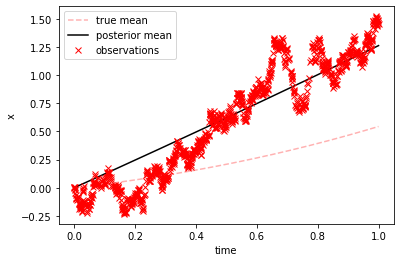

In [59]:
plt.plot(true_sde.pts, true_mean(true_sde.pts), color='r', alpha=0.3, linestyle='dashed', label="true mean")
plt.plot(true_sde.pts, post_mean(true_sde.pts), color='black', label="posterior mean")
plt.plot(true_sde.pts, true_sde.trj, 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

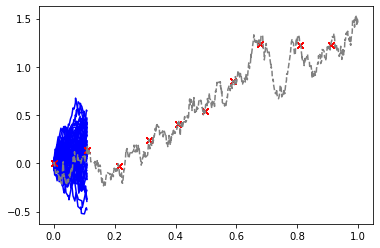

In [61]:
for i in range(50):
    posterior = OU(t0 = obs_time[0], t1 = obs_time[1], z0 = obs[0], m0 = true_sde.m0, alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
    plt.plot(posterior.pts, posterior.trj, 'b')
    plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

**Trace plot: gradient**

In [ ]:
plt.title("Trace plot: beta")
plt.plot(np.arange(len(trace_pars)), trace_beta)
plt.axhline(1.0, xmin=0.01, xmax=300, color='red', label='prior')
plt.legend()
plt.xlabel("iteration")
plt.ylabel(r"$\beta$")
plt.show()

**Trace plot: ELBO**

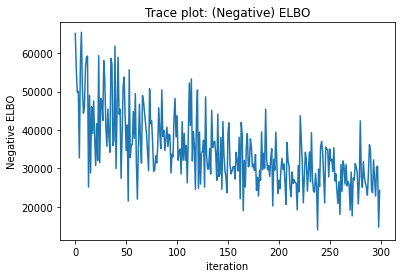

In [56]:
plt.title("Trace plot: (Negative) ELBO")
plt.plot(np.arange(len(trace_elbo)), trace_elbo)
plt.xlabel("iteration")
plt.ylabel("Negative ELBO")
plt.show()

**Posterior moment based on the average of last 30 iterations of beta**

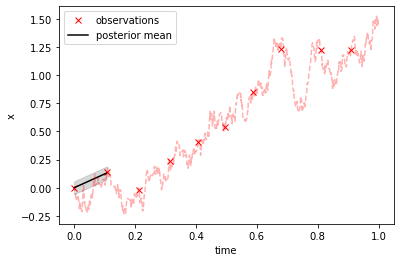

In [76]:
postmean = post_mean(true_sde.pts[:100])

plt.plot(obs_time, obs, 'rx', label="observations")
plt.plot(true_sde.pts[:100], postmean, color='black', label="posterior mean")
plt.plot(true_sde.pts,true_sde.trj, 'red', linestyle='dashed', alpha= 0.3)
plt.fill_between(true_sde.pts[:100], postmean - 0.5/r_, postmean + 0.5/r_, color='grey', alpha=0.3)
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

2. Complete piece-wise optimization from t=0 to t=10

We use the posterior mean of the previous step as our initial value for next vi

In [96]:
N = 50
N_e = 50
learning_rate = 0.00001
z0 = obs[0]
IT = 100

elbo_traces = np.empty((9, IT))
pars_traces = np.empty((3, 9, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    beta_ = np.random.uniform(1, 3)
    alpha_ = np.random.uniform(1, 2)
    r_ = np.random.uniform(0, 1)
  
    for i in range(IT):
        beta_grad = 0.
        alpha_grad = 0.
        r_grad = 0.
        
        for k in range(N):
            vi = OU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0, m0 = true_sde.m0, alpha = alpha_ , beta = beta_ , sigma = 1., r = r_, dN=30)
            elbo = ELBO(vi)
            score = Score(vi)

            scores = score.compute_score(torch.tensor(alpha_, dtype=torch.float64), torch.tensor(beta_, dtype=torch.float64)\
                            , torch.tensor(m0, dtype=torch.float64), torch.tensor(r_, dtype=torch.float64))

            f_of_X = -1 * (elbo.log_prob(obs[t+1]) + elbo.KL_ito() + elbo.KL_rest())
            
            beta_grad += f_of_X * scores['beta']
            alpha_grad += f_of_X * scores['alpha']
            r_grad += f_of_X * scores['r']
            
        beta_ -= learning_rate * (beta_grad/N).numpy()
        alpha_ -= learning_rate * (alpha_grad/N).numpy()
        r_ -= learning_rate * 0.1 * (r_grad/N).numpy()
        
        pars_traces[0, t, i] = alpha_
        pars_traces[1, t, i] = beta_
        pars_traces[2, t, i] = r_
        
        elbo_estimate = 0
        for j in range(N_e):
            vi_ = OU(t0 = obs_time[t], t1=obs_time[t+1], z0 = z0, m0 = true_sde.m0, alpha = alpha_, beta = beta_ , sigma = 1., r = r_, dN=30)
            elbo_ = ELBO(vi_)
            elbo_estimate += -1 * (elbo_.log_prob(obs[t+1]) + elbo_.KL_ito() + elbo_.KL_rest())
    
        elbo_estimate *= 1/N_e
        if i % 10 == 0:
            print("alpha = ", alpha_, "beta = ", beta_, "r = ", r_, "elbo = ", elbo_estimate)
        elbo_traces[t, i] = elbo_estimate

    z0 =  alpha_ * (((obs_time[t+1] + 1) ** np.mean(pars_traces[1, t, -30:])) - 1) + true_sde.m0
    
# score.compute_score()

  0%|                                                     | 0/9 [00:00<?, ?it/s]

alpha =  1.5143614459492236 beta =  1.1828105504634845 r =  0.030859268111763247 elbo =  tensor(38192.7145, dtype=torch.float64)
alpha =  1.4849146371688446 beta =  1.1761752390044964 r =  0.0927664593920664 elbo =  tensor(62049.4413, dtype=torch.float64)
alpha =  1.3125182218833311 beta =  0.9514144618580868 r =  0.12728469108657936 elbo =  tensor(65481.7481, dtype=torch.float64)
alpha =  1.4275703481824633 beta =  1.1312283210951553 r =  0.1830152078417512 elbo =  tensor(46074.0641, dtype=torch.float64)
alpha =  1.0239553557226508 beta =  0.6357510702799102 r =  0.2433136010285259 elbo =  tensor(79722.9520, dtype=torch.float64)
alpha =  1.1632917195865773 beta =  0.8866344134636472 r =  0.2897798352004302 elbo =  tensor(45752.0458, dtype=torch.float64)
alpha =  1.162440049903549 beta =  0.9154211949135607 r =  0.3539343990358267 elbo =  tensor(60799.9164, dtype=torch.float64)
alpha =  1.2204262690781345 beta =  1.0506850632880773 r =  0.41434940903182943 elbo =  tensor(44268.0739, dt

 11%|█████                                        | 1/9 [00:28<03:44, 28.05s/it]

alpha =  1.0359197195008547 beta =  -0.2748757596503326 r =  0.04562627090300727 elbo =  tensor(75446.4361, dtype=torch.float64)
alpha =  1.3839088415165268 beta =  -0.9579346497524281 r =  0.10893368800487085 elbo =  tensor(64435.4207, dtype=torch.float64)
alpha =  1.7052604534857165 beta =  -1.3419018380617154 r =  0.18640527877355964 elbo =  tensor(60291.2307, dtype=torch.float64)
alpha =  1.5424214447672855 beta =  -1.1970902451317238 r =  0.2360323993292241 elbo =  tensor(56551.7166, dtype=torch.float64)
alpha =  1.7203435192576366 beta =  -1.3839902779107682 r =  0.2800292362818658 elbo =  tensor(54801.1188, dtype=torch.float64)
alpha =  1.6671198062728447 beta =  -1.3424148983535031 r =  0.3253775393079722 elbo =  tensor(44388.7277, dtype=torch.float64)
alpha =  1.6757149435110779 beta =  -1.3602290303812874 r =  0.38001246006408174 elbo =  tensor(53517.1025, dtype=torch.float64)
alpha =  1.5560007368207314 beta =  -1.2550739631736723 r =  0.41059425749959194 elbo =  tensor(5054

 22%|██████████                                   | 2/9 [00:56<03:17, 28.17s/it]

alpha =  1.4911528945939092 beta =  2.5740108259474264 r =  0.7230787804903344 elbo =  tensor(41375.6828, dtype=torch.float64)
alpha =  1.1005464693813565 beta =  1.1294003528590495 r =  0.7595710973863333 elbo =  tensor(121735.1198, dtype=torch.float64)
alpha =  0.19307932274315043 beta =  -0.3918160715932806 r =  0.7772633240615591 elbo =  tensor(187569.9212, dtype=torch.float64)
alpha =  -2.0632568298391725 beta =  -1.8033026112155137 r =  0.9810361092901858 elbo =  tensor(91267.5405, dtype=torch.float64)
alpha =  -3.3461888010295078 beta =  -2.672549937090632 r =  1.1287534182530718 elbo =  tensor(41938.1048, dtype=torch.float64)
alpha =  -3.2618966750407536 beta =  -2.618352853860566 r =  1.16471242442295 elbo =  tensor(42498.4619, dtype=torch.float64)
alpha =  -3.5442429344438793 beta =  -2.8031475147613154 r =  1.2345516641692165 elbo =  tensor(43294.3823, dtype=torch.float64)
alpha =  -3.4369843502937325 beta =  -2.7405969270612367 r =  1.2625548516508995 elbo =  tensor(37836.8

 33%|███████████████                              | 3/9 [01:24<02:48, 28.15s/it]

alpha =  -5.099993111613657 beta =  -3.8447136258163903 r =  0.692664142783989 elbo =  tensor(1601120.7326, dtype=torch.float64)
alpha =  5.537643667927811 beta =  -4.087073616345606 r =  1.5853241810563825 elbo =  tensor(42649.8623, dtype=torch.float64)
alpha =  5.67336300309635 beta =  -4.114466643871987 r =  1.6471158881642471 elbo =  tensor(32236.0102, dtype=torch.float64)
alpha =  5.9723769774477065 beta =  -4.182259287474461 r =  1.7610056601431345 elbo =  tensor(41008.3087, dtype=torch.float64)
alpha =  5.643139856155671 beta =  -4.106925491134787 r =  1.7111769790190163 elbo =  tensor(40259.5839, dtype=torch.float64)
alpha =  5.8708613598430235 beta =  -4.162692120365829 r =  1.7902022506652362 elbo =  tensor(71268.5718, dtype=torch.float64)
alpha =  5.7380568457851995 beta =  -4.140405589190287 r =  1.799171771262503 elbo =  tensor(44539.1093, dtype=torch.float64)
alpha =  5.590280530416764 beta =  -4.110706552847235 r =  1.8026024906428118 elbo =  tensor(26590.4836, dtype=tor

 44%|████████████████████                         | 4/9 [01:52<02:20, 28.14s/it]

alpha =  32.346375880775476 beta =  43.45930764092214 r =  4.558168785270563 elbo =  tensor(7.9545e+23, dtype=torch.float64)


/var/folders/2c/_gzbr1y51ws47zfknhxm868h0000gr/T/ipykernel_96457/3779530850.py:27: RuntimeWarning: overflow encountered in exp
  mean = (output[t-1] - beta_t[t-1]) * np.exp(-1 * self.r * interval[t-1] )


alpha =  nan beta =  nan r =  nan elbo =  tensor(nan, dtype=torch.float64)
alpha =  nan beta =  nan r =  nan elbo =  tensor(nan, dtype=torch.float64)
alpha =  nan beta =  nan r =  nan elbo =  tensor(nan, dtype=torch.float64)
alpha =  nan beta =  nan r =  nan elbo =  tensor(nan, dtype=torch.float64)
alpha =  nan beta =  nan r =  nan elbo =  tensor(nan, dtype=torch.float64)
alpha =  nan beta =  nan r =  nan elbo =  tensor(nan, dtype=torch.float64)
alpha =  nan beta =  nan r =  nan elbo =  tensor(nan, dtype=torch.float64)
alpha =  nan beta =  nan r =  nan elbo =  tensor(nan, dtype=torch.float64)
alpha =  nan beta =  nan r =  nan elbo =  tensor(nan, dtype=torch.float64)


 56%|█████████████████████████                    | 5/9 [02:20<01:52, 28.11s/it]

alpha =  nan beta =  nan r =  nan elbo =  tensor(nan, dtype=torch.float64)
alpha =  nan beta =  nan r =  nan elbo =  tensor(nan, dtype=torch.float64)


 56%|█████████████████████████                    | 5/9 [02:25<01:56, 29.08s/it]


KeyboardInterrupt: 

Trace plot: ELBO

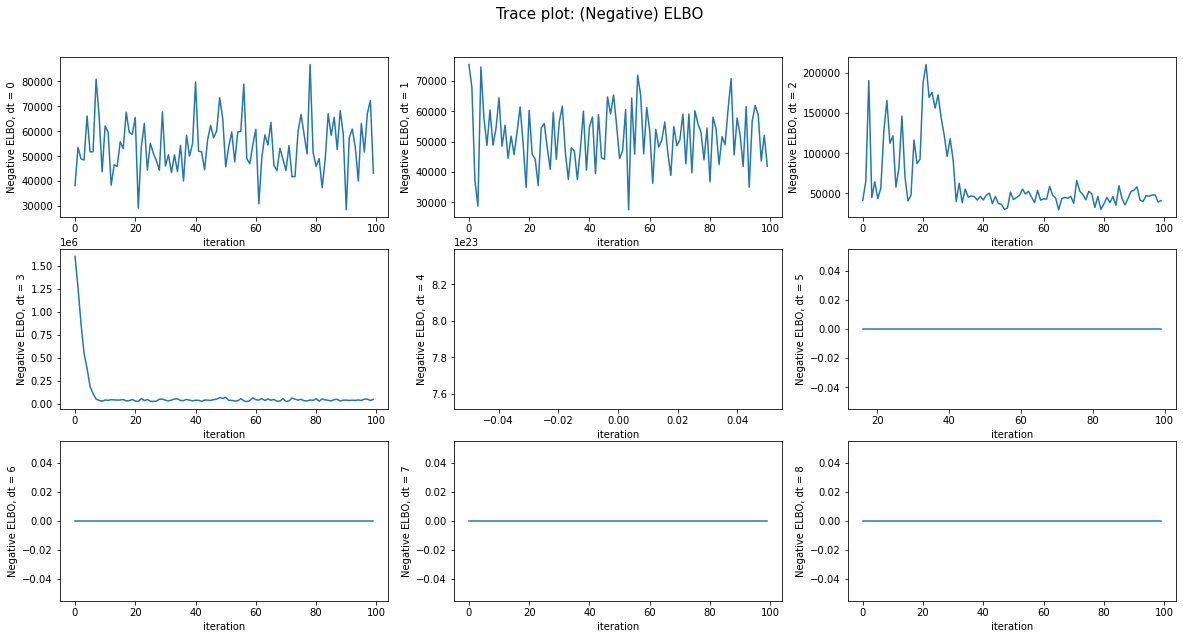

In [97]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :IT])), elbo_traces[t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

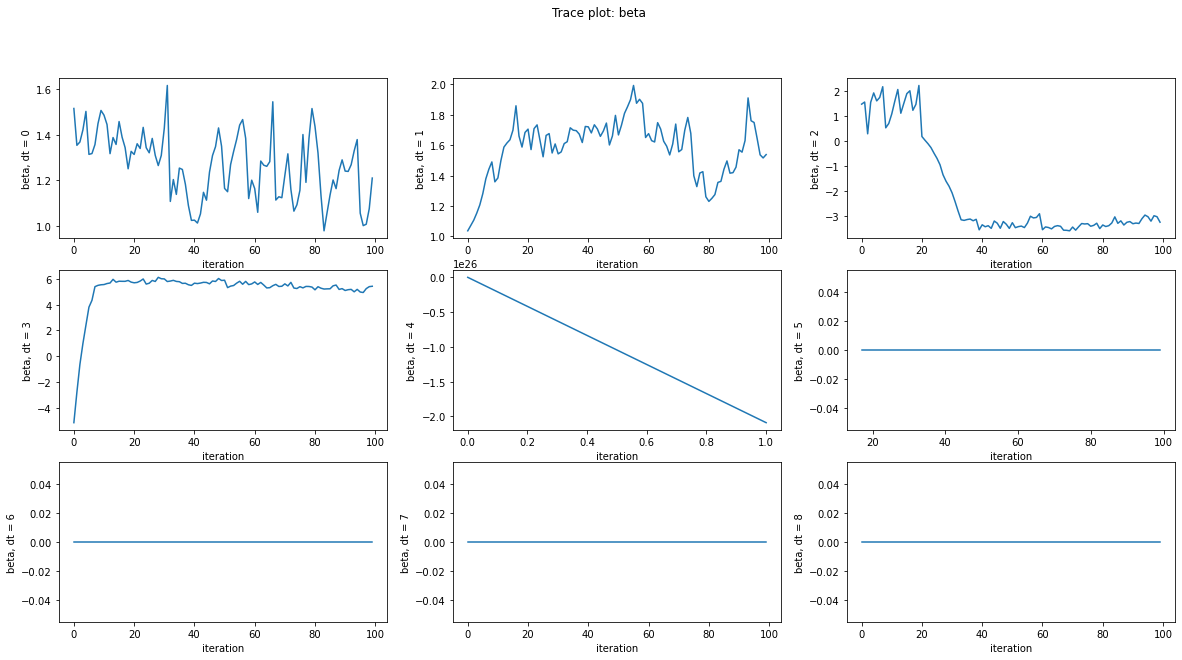

In [98]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(pars_traces[0, t, :IT])), pars_traces[0, t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("beta, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: beta")
plt.show()

In [ ]:
def g_posterior_moment(init, alpha, vi_beta, t0, t1):
    """
        Obtain credible interval
            posterior mean and variance are computed based on the theory (using fitted variational parameter at each interval)
    """
    sigma = 1.
    pts = np.linspace(t0,t1,900)
    dt = pts[1:] - pts[:-1]
    
    mean = [init]
    var = list(map(lambda t: np.sqrt((sigma ** 2 / (2*vi_beta[0])) * (1 - np.exp(-2 * vi_beta[0] * t))), dt[:100]))
    
    k = 0
    for j in range(dt.shape[0]):
        if j % 100 == 0:
            beta = vi_beta[k]
            k += 1
        mean.append(alpha + (mean[j] - alpha)*np.exp(-1 * beta * dt[j]))
        if (j % 100 == 0) and (j > 0):
            func = lambda t: np.sqrt((sigma ** 2 / (2*beta)) * (1 - np.exp(-2 * beta * t)))
            var += list(map(func, dt[j-100:j]))
    return np.array(mean), np.array(var)

In [ ]:
pmean, pvar = g_posterior_moment(obs[0], 0, vi_beta, 0, 6)

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Posterior process")
plt.plot(true_sde.pts, true_sde.trj, alpha=0.3, label='underlying SDE')
plt.plot(true_sde.pts[:900], pmean, 'black', label='posterior mean')
plt.fill_between(true_sde.pts[:900], pmean - pvar, pmean + pvar, alpha=0.5, color='grey')
plt.plot(obs_time, obs, 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()